# Goals and data

<font size=3>
    
The main goal of this project is a text classification of Amazon products' reviews taken from the following [link](https://snap.stanford.edu/data/web-Amazon.html). <br> For computational reasons the amount of data is limited to $9$ different cateories:
* Baby
* Cell_Phones_and_Accessories
* Digital_Music
* Musical_Instruments
* Office_Products
* Pet_Supplies
* Toys_and_Games
* Tools_and_Home_Improvement
* Video_Games

In [131]:
# Data
import time
import numpy as np
import pandas as pd 
import json

# Preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.colors
import matplotlib.pyplot as plt

# Models
import sklearn
from sklearn import model_selection, naive_bayes, metrics, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import chi2


path = "C:\\path\\"

# Caricamento file

<font size=3>
    
Every file should be located in the same folder as they can be loaded with the ``for`` cycle. Files are in ``.json`` format with an unsupported ending structure which was leading to a error while reading, the solution is to replace the unsupported structure with a standard one. <br>
At each iteration data are stored into a ``pandas`` dataframe. There are a lot of information available but only the review's text and its category are kept for analysis. In a previous attempt the review's name was kept as well, but usually they were really short ($4$ words in average) and they did not add any contribution to the classification task.
<br>
Once again for computational reasons, only $1/5$ of the observations are taken for each class, randomly selected with a seed in order to have replicable results.

In [132]:
filename = ["Baby", "Cell_Phones_and_Accessories", "Digital_Music", "Musical_Instruments", "Office_Products", "Pet_Supplies",
            "Toys_and_Games", "Tools_and_Home_Improvement", "Video_Games"]
shortfilename = ['Baby', 'Phones', 'Music', 'Instrument', 'Office', 'Pet', 'Toys', 'Tools', 'VGames']
data  = pd.DataFrame(columns = ["reviewText", "summary", "category"])

for i in range(len(filename)):
    with open(path + filename[i] + "_5.json") as f:
        temp = json.loads("[" + 
            f.read().replace("}\n{", "},\n{") + 
        "]")
    
    temp = pd.DataFrame.from_records(temp)
    temp['category'] = filename[i]
    temp = temp[['reviewText','summary','category']]
    
    print("Numero di osservazioni di " + filename[i] + ": " + str(int(len(temp)/5)))
    data = pd.concat([data, temp.sample(int(len(temp)/5), random_state = 0)], ignore_index = True)

Numero di osservazioni di Baby: 32158
Numero di osservazioni di Cell_Phones_and_Accessories: 38887
Numero di osservazioni di Digital_Music: 12941
Numero di osservazioni di Musical_Instruments: 2052
Numero di osservazioni di Office_Products: 10651
Numero di osservazioni di Pet_Supplies: 31567
Numero di osservazioni di Toys_and_Games: 33519
Numero di osservazioni di Tools_and_Home_Improvement: 26895
Numero di osservazioni di Video_Games: 46356


# Pre-processing

<font size=3>
    
Loading the english stopwords corpus from ``ntlk`` with some more common words.

In [133]:
# Stopwords
stop = stopwords.words('english')
newstop = ['would', 'also', 'even', 'come', 'still', 'around', 'could', 'im', 'cant', 'withuot', 'always', 'definitely', 'u', 
           'probably', 'ive', 'youre', 'etc', 'wont', 'id', 'wasnt'] # Some more stopwords
stop = stop + newstop

# Lemmatizer
lemmatizer = WordNetLemmatizer()

## Tokenization

<font size=3>
    
Tokenization is made at each step of pre-processing.

## Normalizzazione

<font size=3>
    
In this step words are converted into a lower case form and all the special characters are removed.

In [134]:
# example doc
original = data["reviewText"][166113]

In [135]:
%%time

# Lower case
data["reviewText"] = data["reviewText"].apply(lambda x: " ".join(x.lower() for x in x.split()))
norm1 = data["reviewText"][166113]

# Remove special characters
data["reviewText"] = data["reviewText"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',' ')

norm2 = data["reviewText"][166113]

Wall time: 14 s


## Lemmatization

<font size=3>

Lemmatization aims to bring each word to its base form. Since on word belong to different part of speech depending on the sentence, there's no way to be $100%$ of which is the correct one. Some methods involves ``POS-tagging`` based on a literature corpus to estimate the likelihood of one word to belong to a part of speech.
<br>
Without implementing these techniques, another fast, but less accurate, solution is to replicate the process for each part of speech.

In [136]:
%%time

# lemmatization for verbs, nound and adjectives
data["reviewText"] = data["reviewText"].apply(lambda x: " ".join([lemmatizer.lemmatize(word, 'v') for word in x.split()]))
data["reviewText"] = data["reviewText"].apply(lambda x: " ".join([lemmatizer.lemmatize(word, 'n') for word in x.split()]))
data["reviewText"] = data["reviewText"].apply(lambda x: " ".join([lemmatizer.lemmatize(word, 'a') for word in x.split()]))

lem = data["reviewText"][166113]

Wall time: 6min 43s


## Stopwords removal

<font size=3>
    
Stopwords are removed along with words of length $3$ or less.

In [137]:
%%time

# stopwords
data["reviewText"] = data["reviewText"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# words with 3 or less characters
data["reviewText"] = data["reviewText"].apply(lambda x: " ".join(x for x in x.split() if len(x) > 2))

stopw = data["reviewText"][166113]

Wall time: 1min 24s


In [138]:
print("Documento originale: \n" + original + "\n")
print("Lower case: \n" + norm1 + "\n")
print("Punteggiatura: \n" + norm2 + "\n")
print("Lemmizzazione: \n" + lem + "\n")
print("Stopwords: \n" + stopw + "\n")

Documento originale: 
GREAT light so far....after 8 months it is going strong ...i hope it lasts....i can believe it has a motion sensor....!!

Lower case: 
great light so far....after 8 months it is going strong ...i hope it lasts....i can believe it has a motion sensor....!!

Punteggiatura: 
great light so far    after 8 months it is going strong    i hope it lasts    i can believe it has a motion sensor      

Lemmizzazione: 
great light so far after 8 month it be go strong i hope it last i can believe it have a motion sensor

Stopwords: 
great light far month strong hope last believe motion sensor



## Test and train set

<font size=3>
    
Dataset is split into train and test set (default proportion of $75$% and $25$% respectively) using a category stratification to keep the observations' ratio constant. 
<br>
A vector using weights obtained from ``TF-IDF`` method is created (maximum of $5000$ features). The upper limit for features is not random: with more of them it is possible to have more information but usually these terms are so rare that they do not help in the classification process, they can actually lead to even worst performance.

In [139]:
# Train e test
X_train, X_test, y_train, y_test = train_test_split(data["reviewText"], data["category"], stratify = data["category"],
                                                    random_state = 0)

# TF-IDF
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
features_array = tfidf_vect.transform(X_train)

In [140]:
terms = tfidf_vect.get_feature_names()
sums = xtrain_tfidf.sum(axis=0) # sum of weight for each feature

d = []
for col, term in enumerate(terms):
    d.append((term, sums[0,col])) # features are in alphabetical order
    
ranking = pd.DataFrame(d, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False))

              term         rank
1869          game  8066.423453
1908           get  5171.124370
3034           one  5112.184133
4739           use  5062.768812
2555          like  4933.389462
1946          good  4798.915780
1988         great  4784.182394
2611          love  4767.242209
3255          play  4094.619218
4945          work  3937.590799
620            buy  3852.727179
2654          make  3605.837608
4880          well  3431.368639
4527          time  3357.305376
675           case  3242.982623
3527        really  3152.054645
3203         phone  3066.328332
2578        little  2788.052550
3387       product  2736.055421
2598          look  2730.644634
1428          easy  2721.351741
3033           old  2648.522896
2861          much  2591.796810
4582           toy  2546.017098
1316           dog  2504.114864
3362         price  2328.120556
2914          need  2321.664748
4978          year  2320.260669
1843           fun  2312.343663
4493         think  2291.508027
...     

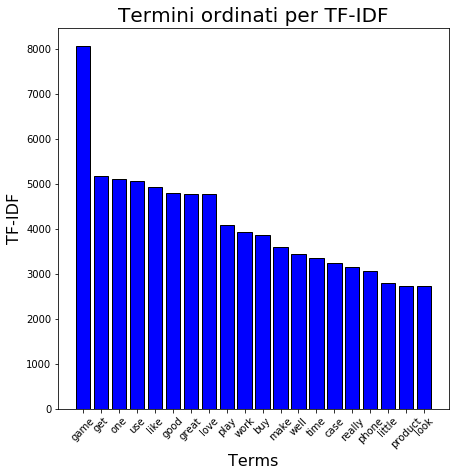

In [141]:
# graph
sort = ranking.sort_values('rank', ascending=False)
sort = sort.iloc[0:20]

plt.figure(figsize=(7,7))
plt.bar(sort["term"], sort["rank"], color="blue", edgecolor = "black")
plt.title('Termini ordinati per TF-IDF', fontsize=20)
plt.xlabel('Terms', fontsize=16)
plt.ylabel('TF-IDF', fontsize=16)
plt.xticks(rotation=45)
fig = plt.gcf()

In [142]:
# New colormap
norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "lightyellow"],
          [norm(-0.95), "antiquewhite"],
          [norm(-0.8), "wheat"],
          [norm(-0.3), "navajowhite"],
          [norm( 0.3), "orange"],
          [norm( 0.8), "tomato"],
          [norm( 0.9), "red"],
          [norm( 1.0), "darkred"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# Classification models

In [143]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, method):
    
    # train classification
    classifier.fit(feature_vector_train, label)
    
    # prediction on test
    predictions = classifier.predict(feature_vector_valid)
    
    # report
    print(classification_report(y_test, predictions))
    
    # confusion matrix
    cm = confusion_matrix(predictions, y_test)
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    fig.colorbar(cax)

    plt.title('Confusion matrix of ' + method, pad=40)
    ax.set_xticklabels([''] + shortfilename, rotation=45)
    ax.set_yticklabels([''] + shortfilename)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return metrics.accuracy_score(predictions, y_test)

## Naive Bayes

                             precision    recall  f1-score   support

                       Baby       0.87      0.87      0.87      8039
Cell_Phones_and_Accessories       0.84      0.95      0.89      9722
              Digital_Music       0.98      0.96      0.97      3235
        Musical_Instruments       0.94      0.31      0.46       513
            Office_Products       0.94      0.78      0.86      2663
               Pet_Supplies       0.93      0.90      0.92      7892
 Tools_and_Home_Improvement       0.85      0.84      0.85      6724
             Toys_and_Games       0.83      0.84      0.83      8380
                Video_Games       0.92      0.91      0.92     11589

                  micro avg       0.88      0.88      0.88     58757
                  macro avg       0.90      0.82      0.84     58757
               weighted avg       0.89      0.88      0.88     58757

[[ 6969    84     8    22    69   285   200   380    16]
 [  173  9222     5   137   179    96   478

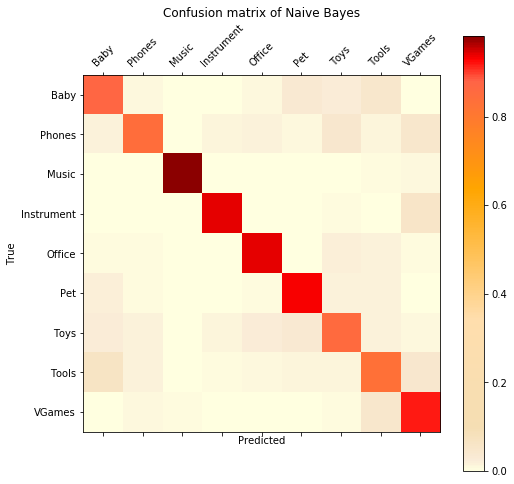

NB, WordLevel TF-IDF:  0.8834181459230389


In [144]:
xtest_tfidf =  tfidf_vect.transform(X_test)
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf, "Naive Bayes")
print ("NB, WordLevel TF-IDF: ", accuracy)

In [145]:
# Example of classification
clf = MultinomialNB().fit(xtrain_tfidf, y_train)

print("Esempio recensione: \n" + X_test.iloc[0] + "\nClasse: " + y_test.iloc[0] + "\n")

print("Classe predetta :")
print(clf.predict(tfidf_vect.transform([X_test.iloc[0]])))

Esempio recensione: 
everything ballista great construction look feel well shoot everyone show want one one surprisingly sturdy high quality item fun love
Classe: Toys_and_Games

Classe predetta :
['Toys_and_Games']


## Random Forest

0.20.1
Number of trees: 10
                             precision    recall  f1-score   support

                       Baby       0.82      0.80      0.81      8039
Cell_Phones_and_Accessories       0.83      0.91      0.87      9722
              Digital_Music       0.96      0.94      0.95      3235
        Musical_Instruments       0.90      0.35      0.50       513
            Office_Products       0.86      0.70      0.77      2663
               Pet_Supplies       0.90      0.87      0.88      7892
 Tools_and_Home_Improvement       0.73      0.81      0.77      6724
             Toys_and_Games       0.78      0.77      0.77      8380
                Video_Games       0.92      0.91      0.92     11589

                  micro avg       0.84      0.84      0.84     58757
                  macro avg       0.86      0.78      0.80     58757
               weighted avg       0.85      0.84      0.84     58757

[[ 6415   132     9    21    84   282   256   547    43]
 [  244  8840   

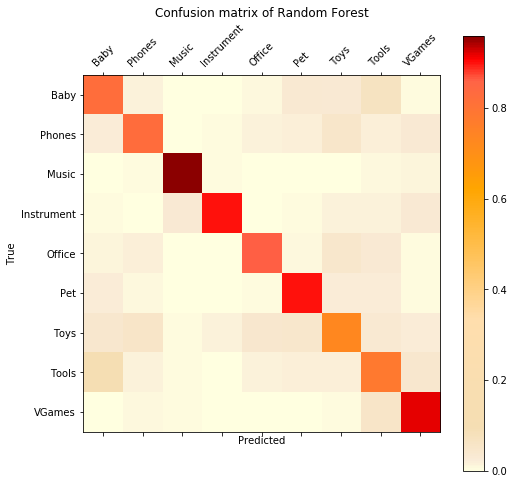

Esecuzione in: 106.789 secondi
RF, WordLevel TF-IDF:  0.8441887775073609


Number of trees: 30
                             precision    recall  f1-score   support

                       Baby       0.85      0.81      0.83      8039
Cell_Phones_and_Accessories       0.84      0.92      0.88      9722
              Digital_Music       0.96      0.95      0.96      3235
        Musical_Instruments       0.91      0.35      0.50       513
            Office_Products       0.88      0.72      0.79      2663
               Pet_Supplies       0.92      0.88      0.90      7892
 Tools_and_Home_Improvement       0.74      0.84      0.79      6724
             Toys_and_Games       0.80      0.79      0.80      8380
                Video_Games       0.93      0.92      0.93     11589

                  micro avg       0.86      0.86      0.86     58757
                  macro avg       0.87      0.80      0.82     58757
               weighted avg       0.86      0.86      0.86     58757

[[ 65

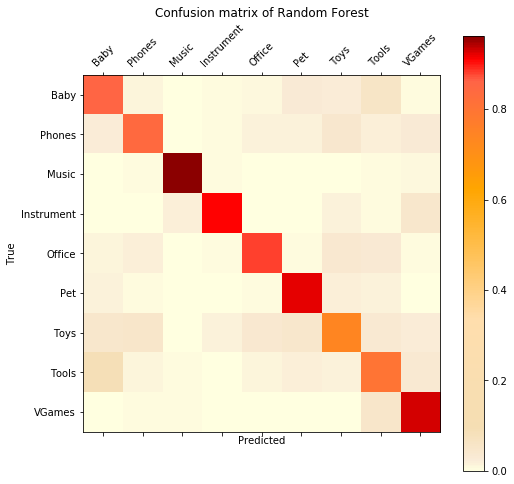

Esecuzione in: 308.767 secondi
RF, WordLevel TF-IDF:  0.8601187943564171


Number of trees: 50
                             precision    recall  f1-score   support

                       Baby       0.86      0.81      0.83      8039
Cell_Phones_and_Accessories       0.84      0.92      0.88      9722
              Digital_Music       0.96      0.95      0.96      3235
        Musical_Instruments       0.92      0.35      0.51       513
            Office_Products       0.90      0.72      0.80      2663
               Pet_Supplies       0.92      0.89      0.91      7892
 Tools_and_Home_Improvement       0.75      0.84      0.79      6724
             Toys_and_Games       0.80      0.80      0.80      8380
                Video_Games       0.93      0.92      0.93     11589

                  micro avg       0.86      0.86      0.86     58757
                  macro avg       0.88      0.80      0.82     58757
               weighted avg       0.87      0.86      0.86     58757

[[ 65

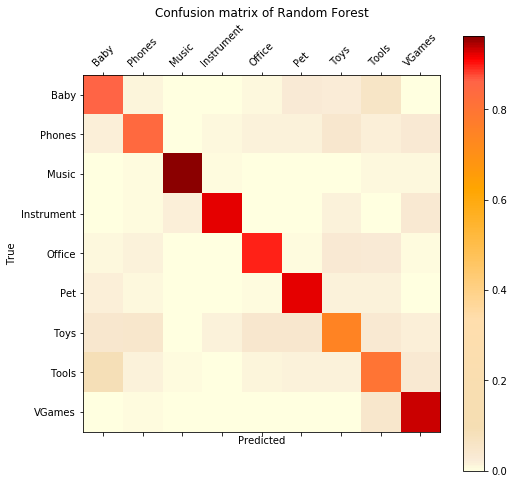

Esecuzione in: 543.545 secondi
RF, WordLevel TF-IDF:  0.8633524516227854


Number of trees: 100
                             precision    recall  f1-score   support

                       Baby       0.87      0.82      0.84      8039
Cell_Phones_and_Accessories       0.84      0.93      0.88      9722
              Digital_Music       0.97      0.95      0.96      3235
        Musical_Instruments       0.93      0.34      0.50       513
            Office_Products       0.90      0.72      0.80      2663
               Pet_Supplies       0.93      0.88      0.90      7892
 Tools_and_Home_Improvement       0.74      0.85      0.79      6724
             Toys_and_Games       0.81      0.80      0.80      8380
                Video_Games       0.93      0.93      0.93     11589

                  micro avg       0.87      0.87      0.87     58757
                  macro avg       0.88      0.80      0.82     58757
               weighted avg       0.87      0.87      0.86     58757

[[ 6

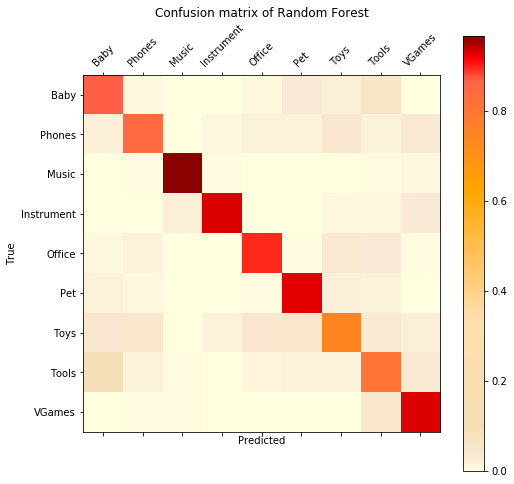

Esecuzione in: 1024.28 secondi
RF, WordLevel TF-IDF:  0.865326684480147




In [146]:
print(sklearn.__version__)

# RF on Word Level TF IDF Vectors
n_trees = [10, 30, 50, 100]

for tree in n_trees:
    start_time = time.time()
    print("Number of trees: " + str(tree))
    accuracy = train_model(ensemble.RandomForestClassifier(n_estimators = tree, min_samples_split = 60), 
                           xtrain_tfidf, y_train, xtest_tfidf, "Random Forest")
    
    print("Esecuzione in: " + str(round(time.time() - start_time, 3)) + " secondi")
    print("RF, WordLevel TF-IDF: ", accuracy)
    print("\n")

## Logistic

C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                             precision    recall  f1-score   support

                       Baby       0.90      0.89      0.89      8039
Cell_Phones_and_Accessories       0.89      0.94      0.92      9722
              Digital_Music       0.98      0.97      0.98      3235
        Musical_Instruments       0.91      0.62      0.74       513
            Office_Products       0.93      0.84      0.88      2663
               Pet_Supplies       0.95      0.92      0.94      7892
 Tools_and_Home_Improvement       0.84      0.89      0.87      6724
             Toys_and_Games       0.86      0.86      0.86      8380
                Video_Games       0.95      0.94      0.95     11589

                  micro avg       0.91      0.91      0.91     58757
                  macro avg       0.91      0.88      0.89     58757
               weighted avg       0.91      0.91      0.91     58757

[[ 7119    65     6    14    51   171   131   328    20]
 [  138  9153    16    57   108    92   288

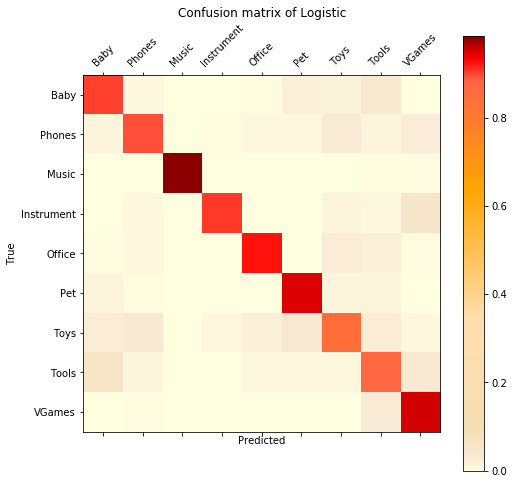

Logistic, WordLevel TF-IDF:  0.9088619228347261


In [147]:
accuracy = train_model(LogisticRegression(random_state=0), xtrain_tfidf, y_train, xtest_tfidf, "Logistic")
print ("Logistic, WordLevel TF-IDF: ", accuracy)

<font size=3>
    
In every single model the recall metric to the class <i>Musical instruments</i> are quite poor (however the precision looks fine). What does this mean? Models rarely assign an observation to this class, but when they do, it is usually the right choice.
<br>
This problem might be related to the number of observation in this class which is significantly lower than the others, a solution might be to consider more observation of this class without using a larger sample of other classes.

## Most correlated words per category

In [148]:
dataprec = data
dataprec['category_id'] = dataprec['category'].factorize()[0]
category_id_dataprec = dataprec[['category', 'category_id']].drop_duplicates().sort_values('category_id')

# dictionaty with category as key and category number as value
category_to_id = dict(category_id_dataprec.values) 

id_to_category = dict(category_id_dataprec[['category_id', 'category']].values)

In [149]:
id_to_category
print(category_to_id.items())
encoder = preprocessing.LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
print(y_train)

dict_items([('Baby', 0), ('Cell_Phones_and_Accessories', 1), ('Digital_Music', 2), ('Musical_Instruments', 3), ('Office_Products', 4), ('Pet_Supplies', 5), ('Toys_and_Games', 6), ('Tools_and_Home_Improvement', 7), ('Video_Games', 8)])
28426                            Baby
138344                 Toys_and_Games
220982                    Video_Games
129043                 Toys_and_Games
106628                   Pet_Supplies
151022                 Toys_and_Games
127460                   Pet_Supplies
83835                   Digital_Music
151691                 Toys_and_Games
158329                 Toys_and_Games
104980                   Pet_Supplies
69337     Cell_Phones_and_Accessories
158942                 Toys_and_Games
105463                   Pet_Supplies
141536                 Toys_and_Games
149755                 Toys_and_Games
207520                    Video_Games
218236                    Video_Games
7273                             Baby
50839     Cell_Phones_and_Accessories
88869

In [202]:
N = 3
labels = y_train_encoded

for Product, category_id in sorted(category_to_id.items()): # product:name, category:number, ('Musical_Instruments', 3)
    features_chi2 = chi2(features_array, labels == category_id)
    indices = np.argsort(features_chi2[0]) #return sorted indexes
    feature_names = np.array(tfidf_vect.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1] #splitta le features
    
    print("# '{}':".format(Product))
    temp = ("{}".format('\n'.join(unigrams[-N:]))) 
    temp2 = temp.split('\n')
    
    # flipped list
    temp2 = temp2[::-1] 
    
    for i in range((N)):
        print(str(i+1) + ". " + temp2[i])
    print()

# 'Baby':
1. baby
2. diaper
3. bottle

# 'Cell_Phones_and_Accessories':
1. phone
2. case
3. charge

# 'Digital_Music':
1. album
2. song
3. quot

# 'Musical_Instruments':
1. pedal
2. guitar
3. string

# 'Office_Products':
1. printer
2. ink
3. paper

# 'Pet_Supplies':
1. dog
2. cat
3. treat

# 'Tools_and_Home_Improvement':
1. doll
2. toy
3. kid

# 'Toys_and_Games':
1. tool
2. light
3. bulb

# 'Video_Games':
1. game
2. graphic
3. play



# New dataset

<font size=3>
    
Let's try to use a larger sample of one category.

In [16]:
with open(path + "Musical_Instruments" + "_5.json") as f:
    temp = json.loads("[" + 
            f.read().replace("}\n{", "},\n{") + 
        "]")
    
    data2 = pd.DataFrame.from_records(temp)
    data2['category'] = "Musical_Instruments"
    data2 = data2[["reviewText", "category"]] 
    print("Numero records " + "Musical_Instruments" + ": " + str(len(data2)))

Numero records Musical_Instruments: 10261


## Pre-processing

In [17]:
# normalizzazione
data2["reviewText"] = data2["reviewText"].apply(lambda x: " ".join(x.lower() for x in x.split()))
data2["reviewText"] = data2["reviewText"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',' ')

# lemmizzazione
data2["reviewText"] = data2["reviewText"].apply(lambda x: " ".join([lemmatizer.lemmatize(word, 'v') for word in x.split()]))
data2["reviewText"] = data2["reviewText"].apply(lambda x: " ".join([lemmatizer.lemmatize(word, 'n') for word in x.split()]))
data2["reviewText"] = data2["reviewText"].apply(lambda x: " ".join([lemmatizer.lemmatize(word, 'a') for word in x.split()]))

# stopwords
data2["reviewText"] = data2["reviewText"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data2["reviewText"] = data2["reviewText"].apply(lambda x: " ".join(x for x in x.split() if len(x) > 2))

## Merge

In [18]:
newdata = data[data.category != "Musical Instruments"]
newdata = pd.concat([data, data2], ignore_index = True)

C:\Users\prowm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Train and test

In [19]:
# Train e test
X_train, X_test, y_train, y_test = train_test_split(newdata['reviewText'], newdata['category'], stratify = newdata["category"],
                                                    random_state = 0)

# TF-IDF
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
xtrain_tfidf =  tfidf_vect.fit_transform(X_train)

                             precision    recall  f1-score   support

                       Baby       0.86      0.87      0.87      8039
Cell_Phones_and_Accessories       0.83      0.95      0.89      9722
              Digital_Music       0.98      0.96      0.97      3235
        Musical_Instruments       0.97      0.78      0.86      3078
            Office_Products       0.94      0.80      0.86      2663
               Pet_Supplies       0.93      0.90      0.91      7892
 Tools_and_Home_Improvement       0.85      0.84      0.85      6724
             Toys_and_Games       0.83      0.84      0.83      8380
                Video_Games       0.92      0.91      0.92     11589

                  micro avg       0.88      0.88      0.88     61322
                  macro avg       0.90      0.87      0.88     61322
               weighted avg       0.89      0.88      0.88     61322

[[ 6973    82     8    65    72   259   194   401    19]
 [  175  9221     5   303   170   112   459

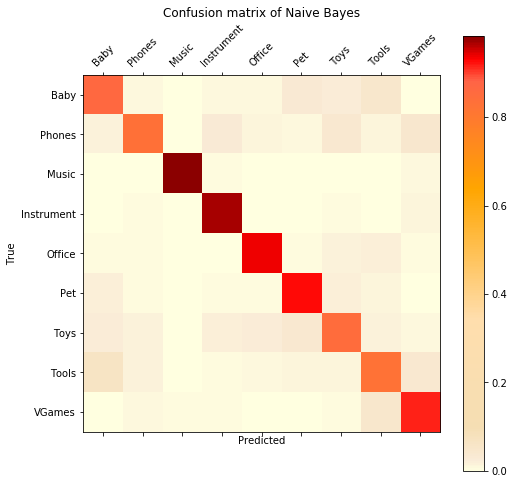

NB, WordLevel TF-IDF:  0.8834675972734092


In [20]:
xtest_tfidf =  tfidf_vect.transform(X_test)
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf, "Naive Bayes")
print ("NB, WordLevel TF-IDF: ", accuracy)

Number of trees: 10
                             precision    recall  f1-score   support

                       Baby       0.83      0.79      0.81      8039
Cell_Phones_and_Accessories       0.83      0.91      0.86      9722
              Digital_Music       0.95      0.93      0.94      3235
        Musical_Instruments       0.90      0.78      0.84      3078
            Office_Products       0.87      0.70      0.77      2663
               Pet_Supplies       0.90      0.86      0.88      7892
 Tools_and_Home_Improvement       0.72      0.81      0.76      6724
             Toys_and_Games       0.78      0.77      0.77      8380
                Video_Games       0.91      0.92      0.91     11589

                  micro avg       0.84      0.84      0.84     61322
                  macro avg       0.85      0.83      0.84     61322
               weighted avg       0.85      0.84      0.84     61322

[[ 6324   113    12    41    94   265   212   538    42]
 [  245  8805    30   1

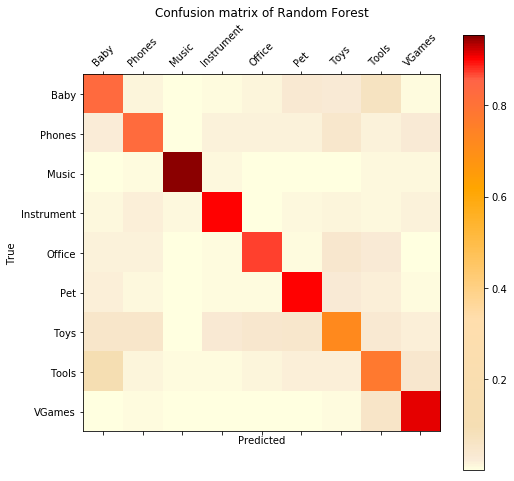

Esecuzione in: 160.633 secondi
RF, WordLevel TF-IDF:  0.8436287140015003


Number of trees: 30
                             precision    recall  f1-score   support

                       Baby       0.85      0.81      0.83      8039
Cell_Phones_and_Accessories       0.84      0.91      0.87      9722
              Digital_Music       0.96      0.95      0.95      3235
        Musical_Instruments       0.92      0.82      0.86      3078
            Office_Products       0.89      0.72      0.80      2663
               Pet_Supplies       0.92      0.88      0.90      7892
 Tools_and_Home_Improvement       0.73      0.83      0.78      6724
             Toys_and_Games       0.80      0.79      0.80      8380
                Video_Games       0.93      0.92      0.92     11589

                  micro avg       0.86      0.86      0.86     61322
                  macro avg       0.87      0.85      0.86     61322
               weighted avg       0.86      0.86      0.86     61322

[[ 64

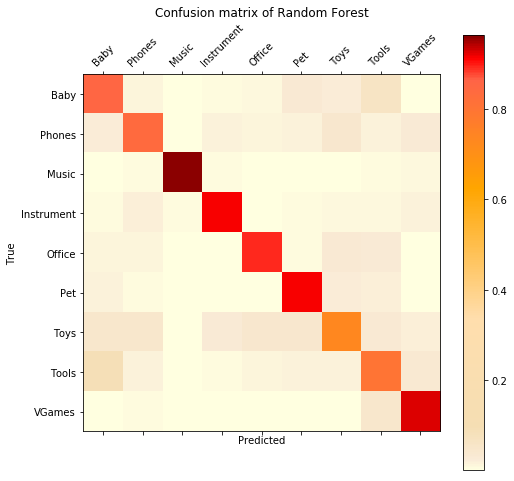

Esecuzione in: 484.045 secondi
RF, WordLevel TF-IDF:  0.8596751573660351


Number of trees: 50
                             precision    recall  f1-score   support

                       Baby       0.86      0.81      0.83      8039
Cell_Phones_and_Accessories       0.84      0.92      0.88      9722
              Digital_Music       0.96      0.95      0.96      3235
        Musical_Instruments       0.92      0.82      0.87      3078
            Office_Products       0.89      0.72      0.80      2663
               Pet_Supplies       0.92      0.87      0.90      7892
 Tools_and_Home_Improvement       0.73      0.84      0.78      6724
             Toys_and_Games       0.81      0.79      0.80      8380
                Video_Games       0.93      0.92      0.93     11589

                  micro avg       0.86      0.86      0.86     61322
                  macro avg       0.87      0.85      0.86     61322
               weighted avg       0.87      0.86      0.86     61322

[[ 65

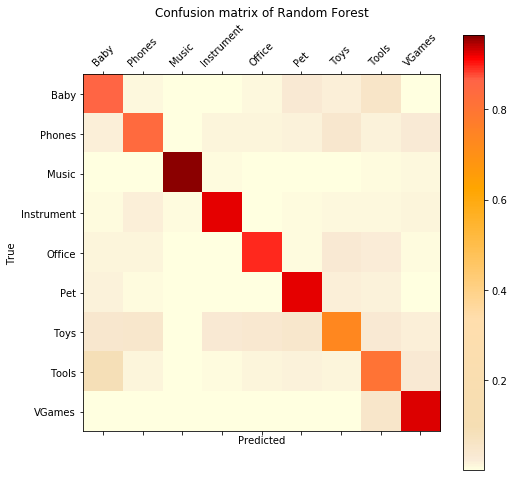

Esecuzione in: 790.784 secondi
RF, WordLevel TF-IDF:  0.8625941750105998


Number of trees: 100
                             precision    recall  f1-score   support

                       Baby       0.86      0.81      0.84      8039
Cell_Phones_and_Accessories       0.84      0.92      0.88      9722
              Digital_Music       0.96      0.95      0.95      3235
        Musical_Instruments       0.92      0.82      0.86      3078
            Office_Products       0.90      0.73      0.81      2663
               Pet_Supplies       0.93      0.88      0.90      7892
 Tools_and_Home_Improvement       0.74      0.84      0.79      6724
             Toys_and_Games       0.81      0.80      0.81      8380
                Video_Games       0.93      0.93      0.93     11589

                  micro avg       0.86      0.86      0.86     61322
                  macro avg       0.88      0.85      0.86     61322
               weighted avg       0.87      0.86      0.86     61322

[[ 6

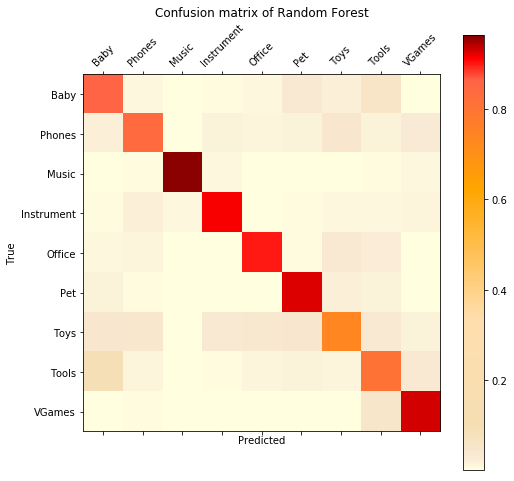

Esecuzione in: 1568.532 secondi
RF, WordLevel TF-IDF:  0.8646489025145951


Wall time: 50min 3s


In [21]:
%%time

n_trees = [10, 30, 50, 100]

for tree in n_trees:
    start_time = time.time()
    print("Number of trees: " + str(tree))
    accuracy = train_model(ensemble.RandomForestClassifier(n_estimators = tree, min_samples_split = 60), 
                           xtrain_tfidf, y_train, xtest_tfidf, "Random Forest")
    
    print("Esecuzione in: " + str(round(time.time() - start_time, 3)) + " secondi")
    print("RF, WordLevel TF-IDF: ", accuracy)
    print("\n")

C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                             precision    recall  f1-score   support

                       Baby       0.90      0.88      0.89      8039
Cell_Phones_and_Accessories       0.89      0.94      0.91      9722
              Digital_Music       0.98      0.97      0.97      3235
        Musical_Instruments       0.94      0.85      0.90      3078
            Office_Products       0.93      0.85      0.89      2663
               Pet_Supplies       0.94      0.92      0.93      7892
 Tools_and_Home_Improvement       0.83      0.88      0.86      6724
             Toys_and_Games       0.87      0.86      0.86      8380
                Video_Games       0.95      0.94      0.94     11589

                  micro avg       0.91      0.91      0.91     61322
                  macro avg       0.91      0.90      0.91     61322
               weighted avg       0.91      0.91      0.91     61322

[[ 7113    68     7    32    48   181   135   335    17]
 [  134  9129    18   139   107    90   294

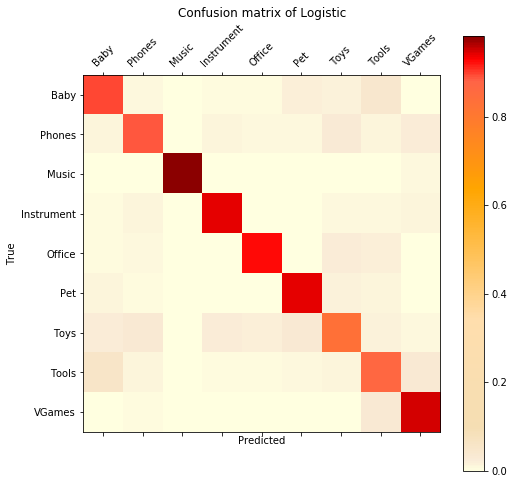

Logistic, WordLevel TF-IDF:  0.9064283617624996


In [22]:
accuracy = train_model(LogisticRegression(random_state=0), xtrain_tfidf, y_train, xtest_tfidf, "Logistic")
print ("Logistic, WordLevel TF-IDF: ", accuracy)

<font size=3>
    
Even with more observation there are no improvements: general accuracy is pretty much the same but recall is way better for <i>Musical instruments</i>.
<br>
In both cases the best model is the Logistic, while the worst is Random Forest. Usually the last one is a good model which performs great in several different tasks, in this case the random selection of feature might be a weak point which leads to these results.

## Numero di features

<font size=3>
    
As last taks, given the best model, the number of features used for ``TF-IDF`` is changed in order to see if there still a margin of improvement.

Number of features: 3000


C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                             precision    recall  f1-score   support

                       Baby       0.88      0.88      0.88      8039
Cell_Phones_and_Accessories       0.88      0.94      0.91      9722
              Digital_Music       0.98      0.96      0.97      3235
        Musical_Instruments       0.93      0.84      0.88      3078
            Office_Products       0.92      0.84      0.88      2663
               Pet_Supplies       0.93      0.91      0.92      7892
 Tools_and_Home_Improvement       0.82      0.87      0.85      6724
             Toys_and_Games       0.86      0.85      0.85      8380
                Video_Games       0.95      0.94      0.94     11589

                  micro avg       0.90      0.90      0.90     61322
                  macro avg       0.91      0.89      0.90     61322
               weighted avg       0.90      0.90      0.90     61322

[[ 7052    75    10    37    62   212   145   362    20]
 [  146  9095    18   160   111    94   303

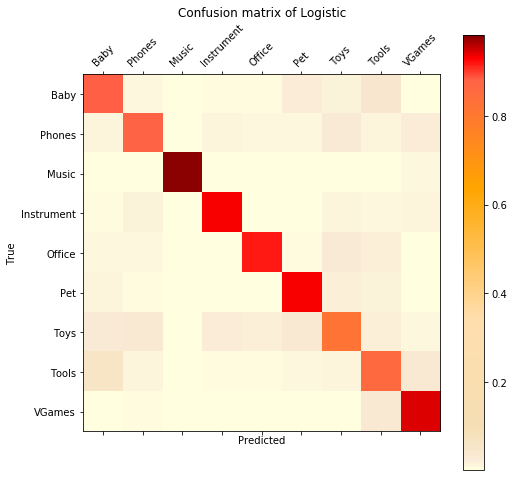

Logistic, WordLevel TF-IDF:  0.899057434525945


Number of features: 10000


C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                             precision    recall  f1-score   support

                       Baby       0.90      0.89      0.89      8039
Cell_Phones_and_Accessories       0.89      0.94      0.92      9722
              Digital_Music       0.98      0.97      0.97      3235
        Musical_Instruments       0.95      0.86      0.90      3078
            Office_Products       0.93      0.85      0.89      2663
               Pet_Supplies       0.95      0.93      0.94      7892
 Tools_and_Home_Improvement       0.84      0.89      0.86      6724
             Toys_and_Games       0.87      0.86      0.87      8380
                Video_Games       0.95      0.94      0.95     11589

                  micro avg       0.91      0.91      0.91     61322
                  macro avg       0.92      0.90      0.91     61322
               weighted avg       0.91      0.91      0.91     61322

[[ 7140    63     8    29    49   169   121   329    16]
 [  127  9152    16   133   105    78   270

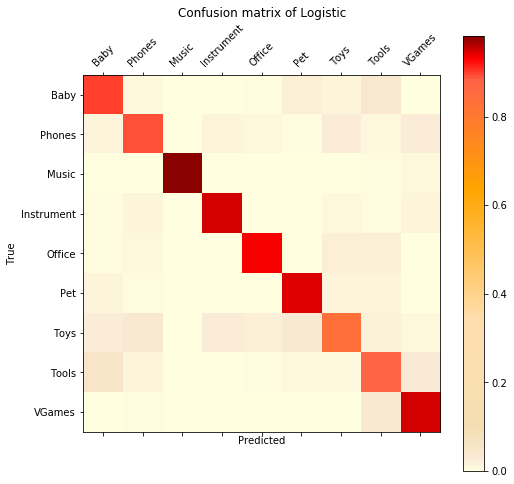

Logistic, WordLevel TF-IDF:  0.9107171977430613


Number of features: 20000


C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                             precision    recall  f1-score   support

                       Baby       0.90      0.89      0.90      8039
Cell_Phones_and_Accessories       0.89      0.94      0.92      9722
              Digital_Music       0.98      0.97      0.97      3235
        Musical_Instruments       0.95      0.86      0.90      3078
            Office_Products       0.93      0.86      0.89      2663
               Pet_Supplies       0.95      0.93      0.94      7892
 Tools_and_Home_Improvement       0.84      0.90      0.87      6724
             Toys_and_Games       0.87      0.87      0.87      8380
                Video_Games       0.95      0.94      0.95     11589

                  micro avg       0.91      0.91      0.91     61322
                  macro avg       0.92      0.91      0.91     61322
               weighted avg       0.91      0.91      0.91     61322

[[ 7154    66     6    29    47   166   120   322    16]
 [  127  9153    15   128   104    75   265

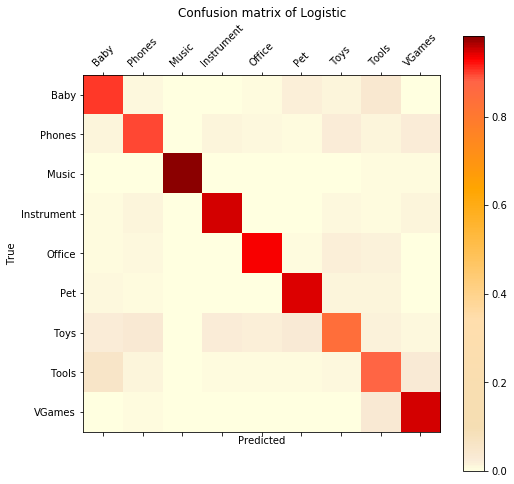

Logistic, WordLevel TF-IDF:  0.9120380939956296


Number of features: 30000


C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                             precision    recall  f1-score   support

                       Baby       0.90      0.89      0.90      8039
Cell_Phones_and_Accessories       0.89      0.94      0.92      9722
              Digital_Music       0.98      0.97      0.97      3235
        Musical_Instruments       0.95      0.86      0.90      3078
            Office_Products       0.93      0.86      0.89      2663
               Pet_Supplies       0.95      0.93      0.94      7892
 Tools_and_Home_Improvement       0.84      0.90      0.87      6724
             Toys_and_Games       0.87      0.87      0.87      8380
                Video_Games       0.95      0.94      0.95     11589

                  micro avg       0.91      0.91      0.91     61322
                  macro avg       0.92      0.91      0.91     61322
               weighted avg       0.91      0.91      0.91     61322

[[ 7155    65     6    30    46   164   119   320    14]
 [  129  9154    15   128   104    74   265

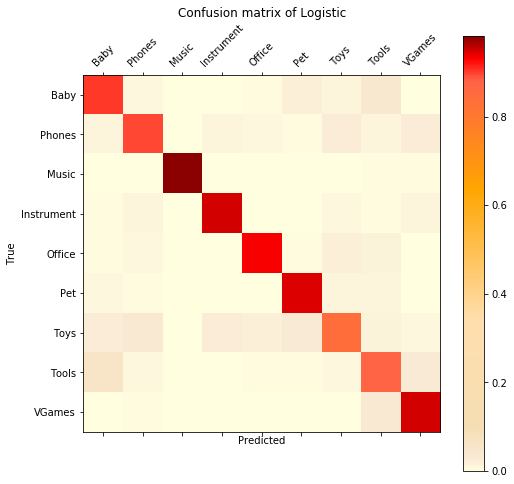

Logistic, WordLevel TF-IDF:  0.9122337823293435


Number of features: 50000


C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\prowm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


                             precision    recall  f1-score   support

                       Baby       0.90      0.89      0.90      8039
Cell_Phones_and_Accessories       0.89      0.94      0.92      9722
              Digital_Music       0.98      0.97      0.97      3235
        Musical_Instruments       0.95      0.86      0.90      3078
            Office_Products       0.94      0.86      0.89      2663
               Pet_Supplies       0.95      0.93      0.94      7892
 Tools_and_Home_Improvement       0.84      0.90      0.87      6724
             Toys_and_Games       0.87      0.87      0.87      8380
                Video_Games       0.95      0.94      0.95     11589

                  micro avg       0.91      0.91      0.91     61322
                  macro avg       0.92      0.91      0.91     61322
               weighted avg       0.91      0.91      0.91     61322

[[ 7150    64     6    30    46   164   118   321    15]
 [  129  9155    15   133   101    74   268

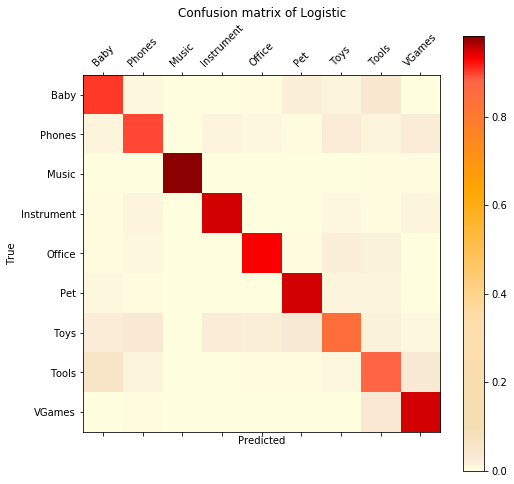

Logistic, WordLevel TF-IDF:  0.9120707087179153




In [28]:
# TF-IDF
n_features = [3000, 10000, 20000, 30000, 50000]
for features in n_features:
    X_train, X_test, y_train, y_test = train_test_split(newdata['reviewText'], newdata['category'], 
                                                        stratify = newdata["category"], random_state = 0)

    
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=features)
    xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
    xtest_tfidf =  tfidf_vect.transform(X_test)
    
    print("Number of features: " + str(features))
    accuracy = train_model(LogisticRegression(random_state=0), xtrain_tfidf, y_train, xtest_tfidf, "Logistic")
    print ("Logistic, WordLevel TF-IDF: ", accuracy)
    print("\n")